In [1]:
import requests, json, os, warnings, re
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# Alpha Vantage API

In this exercise we are going to build a very simple python wrapper for the [Alpha Vantage API](https://www.alphavantage.co/). 

It is a free API to collect stock market data, however it still requires authentication. So, get your [free api key today! ](https://www.alphavantage.co/support/#api-key) Just fill in the form, and get your key (careful, the key is generated in the same webpage, just below the "Get free api key" button). Save this key.

Just one important note, here we are dealing with a real API, not just a Toy one. 

A useful way to work with API keys is to set enviromment variables with the value of the key. Then you can just retrieve them using python `os` package. To create new environment variables:

- On Windows: open Powershell and type: `[Environment]::SetEnvironmentVariable('variable_name', 'variable_value', 'User')`, where `variable_name` is the name for your variable (e.g., ALPHA_API), `variable_value` is your api key, and `Users` is specyfing the scope of the variable (e.g., if you want your variable available to all the users you would use `Machine` instead. But here we don't want that). Note that the variable will be available only in the next sessions.

- On Mac/Linux: `export variable_name=variable_value`. This will make the variable available only in the current session.

- To access an environment variable in a python session you run:
    ```
        import os
        os.environ['variable_name']
    ```

Although there are some wrappers already defined for Alpha Vantage API and we will take advantage of this. 

When you find an useful API that has no wrapper, make your own wrapper, create a package and publish it.

The idea of a wrapper is to create a set of functions to handle the requests for us, so it is easier to work with the API in a specific language.

Now, take a look at the API [documentation](https://www.alphavantage.co/documentation/).

In [2]:
import alpha_vantage
import os


# Put your key here.
os.environ['ALPHA_API'] = "NE20K1OP63DAOK29"

## Step 1

Let us create a function to build and return our request. 

In [3]:
def data_request(params):
    url = "https://www.alphavantage.co/query"
    params['apikey'] = os.environ['ALPHA_API']

    return requests.get(url, params)

In [4]:
params = {"per_page": 100}

In [5]:
data_request(params)

<Response [200]>

## Step 2

Let's make a wrapper function to retrieve a [Stock Time Series](https://www.alphavantage.co/documentation/#time-series-data). Let's focus only in the [daily](https://www.alphavantage.co/documentation/#daily), [weekly](https://www.alphavantage.co/documentation/#weekly), and [monthly](https://www.alphavantage.co/documentation/#monthly), periods. 

Our function should receive the name of the stock and the frequency and return the data in json format.

We should make sure we get the time series of weekly `low` price, weekly `close` price and weekly `high` price, all in the same plot. Let's pick up the `Google` stock.

In [7]:
def Create_Pandas(data_json):
    data = pd.read_json(json.dumps(data_json[list(data_json.keys())[1]])).T
    data.index = pd.to_datetime(data.index)
    
    return data

def Get_TimeSeries(stock, period):
    """
    A wrapper function to obtain the the time series of a the desired stock from the Alpha Vantage API.
    
    Parameters:
    -----------
    stock: the desired stock symbol (e.g., "GOOG", "AMD", "FB", "INTC").
    period: "daily", "weekly", "monthly"
    
    Returns:
    --------
    A pandas dataframe with the columns `open`, `high`, `low`, `close`, and `volume`.
    """
    
    # Let's process the period parameter 
    # which affects the function parameter in the API
    # (I'm using a dictionary here so if the user try a period different from
    # daily, weekly or monthly, an exception will be raised)
    ts_string = "TIME_SERIES_"
    _function = {'DAILY': ts_string + "DAILY",
                 'WEEKLY': ts_string + "WEEKLY",
                 'MONTHLY': ts_string + "MONTHLY"}
    
    # Now let's create a dictionary to hold the parameters of 
    # our request.
    params = {"function": _function[period.upper()],
              "symbol": stock.upper(),
              "outputsize": "full"}
    
    # Requesting the data
    response = data_request(params)
    
    # Check the result of the request
    if response.status_code != 200:
        raise Exception(response.reason)
    if "Error Message" in response.json():
        raise ValueError(response.json()["Error Message"])
        
    # Create the pandas dataframe
    data_json = response.json()
    data = Create_Pandas(data_json)
    data.Stock = data_json['Meta Data']['2. Symbol']
    data.LastUpdate = pd.Period(data_json['Meta Data']['3. Last Refreshed'], freq='D')
    data.columns = [re.split("[1-9]*\. ", column)[1] for column in data.columns] 
    
    return data, data_json

In [8]:
google_weekly, json_google= Get_TimeSeries("GOOG", "WEEKLY")


In [9]:
json_google

{'Meta Data': {'1. Information': 'Weekly Prices (open, high, low, close) and Volumes',
  '2. Symbol': 'GOOG',
  '3. Last Refreshed': '2020-10-26',
  '4. Time Zone': 'US/Eastern'},
 'Weekly Time Series': {'2020-10-26': {'1. open': '1625.0100',
   '2. high': '1638.2400',
   '3. low': '1576.5000',
   '4. close': '1590.4500',
   '5. volume': '1853254'},
  '2020-10-23': {'1. open': '1580.4600',
   '2. high': '1642.3600',
   '3. low': '1525.6700',
   '4. close': '1641.0000',
   '5. volume': '9227878'},
  '2020-10-16': {'1. open': '1543.0000',
   '2. high': '1593.8600',
   '3. low': '1532.5700',
   '4. close': '1573.0100',
   '5. volume': '8990547'},
  '2020-10-09': {'1. open': '1466.2100',
   '2. high': '1516.5200',
   '3. low': '1436.0000',
   '4. close': '1515.2200',
   '5. volume': '6728209'},
  '2020-10-02': {'1. open': '1474.2100',
   '2. high': '1499.0400',
   '3. low': '1449.3012',
   '4. close': '1458.4200',
   '5. volume': '7752219'},
  '2020-09-25': {'1. open': '1440.0600',
   '2. 

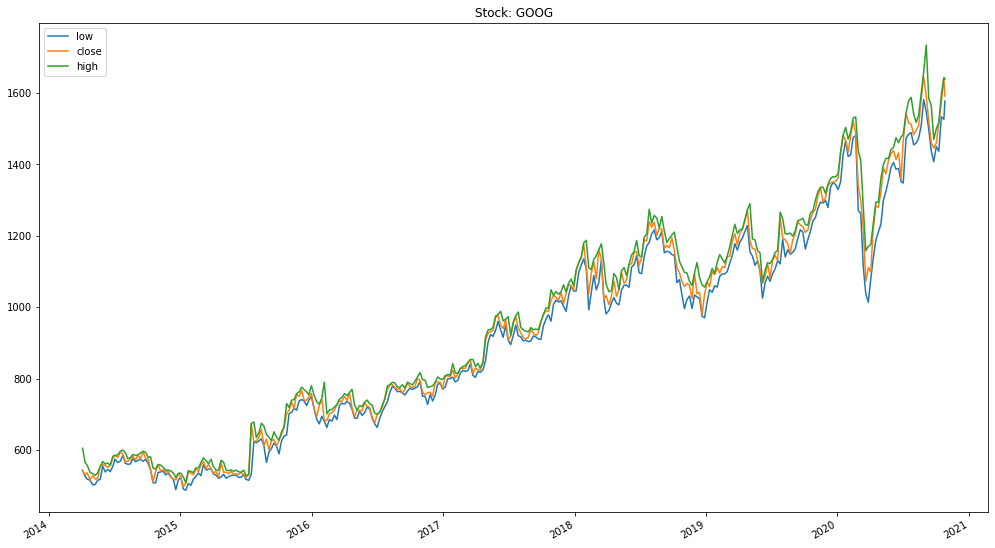

In [38]:
google_weekly[['low', 'close', 'high']].plot(figsize=(17,10), title="Stock: "+ google_weekly.Stock)